# Project 3 for CSE142
## CIFAR-10 Classification

Importing necessary packages:

- tensorflow/keras: API to build and train models
- matplotlib: generate graphs
- numpy: perform array operations
- pandas: to work with dataframes
- pickle: for serializing and de-serializing a Python object
- os: for file paths

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np
import pandas as pd
# import pickle
# import os, os.path
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam

### *Initialize relevant variables*

In [4]:
labels_df = pd.read_csv("Semi3_Labels.csv") #change this for different versions
train_path = 'Train_Image' 
test_path = 'Test_Image' 
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#labels_df

## Defining some functions

In [5]:
def get_image(img_number):
    img = mpimg.imread(train_path + f"/{img_number}.png") 
    return img
def get_test_image(img_number):
    img = mpimg.imread(test_path + f"/{img_number}.png") 
    return img
def get_label(arr):
    max_index_col = np.argmax(arr, axis=0)
    return labels[max_index_col]

In [6]:
# plt.imshow(get_image(7777))

In [7]:
# plt.imshow(get_test_image(999))

**Function that prints image info**

In [8]:
def get_img_info(img):
    rows,cols,channels = img.shape 
    img_size = rows*cols*channels # channels means rgb colors i think, so should always be 3?
    img_to_1D = img.reshape(img_size) #numPy reshape
    print("rows, cols, channels:", rows, cols, channels)
    print("image size:", img_size)
#     print("image original:", img)
#     print("image reshape:", img_to_1D)
#     return img_to_1D

In [9]:
get_img_info(get_image(3)) 

rows, cols, channels: 32 32 3
image size: 3072


## Preprocessing the  Data

We need to separate the labeled data from the unlabeled

Also need to encode labels as numbers instead of strings

In [10]:
#is_unlabelled = labels_df["Train Label"] == NAN
labelled = (labels_df["Train Label"]!= "NAN")
unlabelled = (labels_df["Train Label"] == "NAN")

unlabelled_data = (labels_df[unlabelled])
# print(unlabelled_data)

labelled_data = (labels_df[labelled])
# print(labelled_data)

In [11]:
labeled = []
unlabeled = []

labeled = labelled_data["Train Label"].tolist()
unlabeled = unlabelled_data["Train Label"].tolist()

# print (labeled) 
# print (unlabeled) 

In [12]:
#col = labels_df.columns
#for i, entry in enumerate(labels_df[col[0]]):
 #   if (entry == 'NAN'):
  #      unlabeled.append(i)
   # else:
   #     labeled.append([i, entry])
# print("labeled", labeled)
# print("unlabeled", unlabeled)


4000


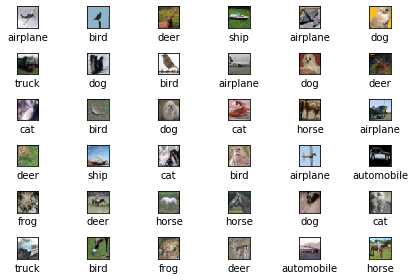

In [13]:
# Need to reshape training data and labels
train_images, train_labels, test_images, test_labels = [], [], [], []
for i in labelled_data.iterrows():
    train_images.append(get_image(i[0]))
    train_labels.append(i[1]['Train Label'])
print(len(train_images))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

In [39]:
# print(train_labels)
print(len(train_labels))

4000


One-Hot Encoding

##### USED FOLLOWING TUTORIAL: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/#:~:text=A%20one%20hot%20encoding%20allows,output%20variables%20that%20are%20categorical.

In [14]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

##One hot 
# print(train_labels)
values = array(train_labels)
copy = values
print(values)

def encode(vals):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(vals) 
    onehot_encoder = OneHotEncoder(sparse =False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

onehot_encoded = encode(values)

['airplane' 'bird' 'deer' ... 'cat' 'frog' 'airplane']


In [15]:
# print(onehot_encoded)
# print(len(onehot_encoded))

In [16]:
#change this to one-hot
# for i in range(len(train_labels)):
#     for j in range(len(labels)):
#         if train_labels[i] == labels[j]:
#             train_labels[i] = j
# print (train_labels)

train_labels = onehot_encoded
print(len(train_labels))

4000


In [17]:
#split labeled data so that we have some labeled testing data 80/20
x = int(0.8*(len(train_images)))
test_images =  np.array(train_images[x:])
train_images = np.array(train_images[:x])
test_labels = np.array(train_labels[x:])
train_labels = np.array(train_labels[:x])
print(len(train_images), len(train_labels), len(test_images), len(test_labels))

# print(train_images, test_images)

3200 3200 800 800


In [18]:
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, restore_best_weights=True)

## Baseline Model

### Convolutional Neural Network

As input, a CNN takes tensors of shape (height, width, channels) = (32, 32, 3)

This is based on https://www.tensorflow.org/tutorials/images/cnn

In [45]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same',input_shape=(32, 32, 3)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
# model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
# model.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
# model.add(layers.Dense(10, activation='softmax'))
# model.summary()

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# # model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# # model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))
# model.summary()

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)       

In [46]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

In [47]:

# datagen = image.ImageDataGenerator(
#     featurewise_center=False,  
#     samplewise_center=False, 
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False, 
#     zca_whitening=False, 
#     rotation_range=0,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=False
# )

# datagen.fit(train_images)

# model.fit_generator(datagen.flow(train_images, train_labels, batch_size=20), epochs=100, 
#                     validation_data=(test_images, test_labels),callbacks=[callback1])

In [48]:
history = model.fit(train_images, train_labels, epochs=100, 
                    validation_data=(test_images, test_labels), callbacks=[callback1])

Train on 3200 samples, validate on 800 samples
Epoch 1/100
3200/3200 [==============================] - 17s 5ms/sample - loss: 2.2222 - accuracy: 0.2247 - val_loss: 2.2696 - val_accuracy: 0.1663
Epoch 2/100
3200/3200 [==============================] - 17s 5ms/sample - loss: 2.1404 - accuracy: 0.3131 - val_loss: 2.2407 - val_accuracy: 0.2000
Epoch 3/100
3200/3200 [==============================] - 17s 5ms/sample - loss: 2.0936 - accuracy: 0.3706 - val_loss: 2.1810 - val_accuracy: 0.2675
Epoch 4/100
3200/3200 [==============================] - 17s 5ms/sample - loss: 2.0606 - accuracy: 0.3941 - val_loss: 2.0778 - val_accuracy: 0.3725
Epoch 5/100
3200/3200 [==============================] - 16s 5ms/sample - loss: 2.0395 - accuracy: 0.4209 - val_loss: 2.0914 - val_accuracy: 0.3562
Epoch 6/100
3200/3200 [==============================] - 17s 5ms/sample - loss: 2.0120 - accuracy: 0.4506 - val_loss: 1.9909 - val_accuracy: 0.4688
Epoch 7/100
3200/3200 [==============================] - 17s 5ms/

## Augmenting the Data



### Label some of our unlabeled data

In [52]:
new_labels = [];
new_images = [];

for j,i in enumerate(unlabelled_data.iterrows()):
    if j < len(test_images):
        new_images.append(get_image(i[0]))
#         print(i[0])


predictions = model.predict(np.array(new_images))
for i in predictions:
    new_labels.append(get_label(i))
    
print(len(new_images), len(new_labels))

800 800


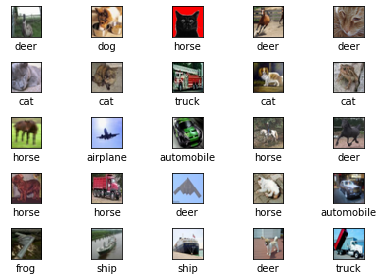

In [53]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow(new_images[i])
    plt.xlabel(new_labels[i])
plt.show()

one-hot encode predicted labels and concatenate with the original labels

In [54]:
new_train_images = np.concatenate((np.array(new_images), train_images), axis=0)

new_train_labels = np.concatenate((new_labels, copy), axis=0)
new_train_labels = encode(new_train_labels)

z = x + len(new_images)
train_labels = np.array(new_train_labels[:z])
print(len(new_train_images),len(train_labels))
print(len(test_labels), len(test_images))



4000 4000
800 800


## Training model with new data

In [55]:
new_model = models.Sequential()
new_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
new_model.add(layers.BatchNormalization())
new_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
new_model.add(layers.BatchNormalization())
new_model.add(layers.MaxPooling2D((2, 2)))
new_model.add(layers.Dropout(0.2))
new_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
new_model.add(layers.BatchNormalization())
new_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
new_model.add(layers.MaxPooling2D((2, 2)))
new_model.add(layers.Dropout(0.3))
new_model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
new_model.add(layers.BatchNormalization())
new_model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
new_model.add(layers.BatchNormalization())
new_model.add(layers.MaxPooling2D((2, 2)))
new_model.add(layers.Dropout(0.4))
new_model.add(layers.Flatten())
new_model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
new_model.add(layers.BatchNormalization())
new_model.add(layers.Dropout(0.5))
new_model.add(layers.Dense(10, activation='softmax'))
new_model.summary()

new_model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = new_model.fit(new_train_images, train_labels, epochs=100, 
                    validation_data=(test_images, test_labels), callbacks=[callback1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)       

Baseline model with augmented data predictions

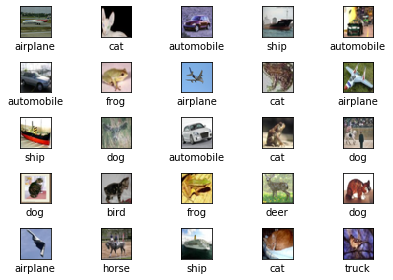

In [56]:
tests = []
for i in range(25):
    tests.append(get_test_image(i))

predictions = new_model.predict(np.array(tests))
    
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow(tests[i])
    plt.xlabel(get_label(predictions[i]))
plt.show()

# ResNet 50 

As per TA recommendation, try a much more complex model

Couldn't get this to work :( val_accuracy doesn't improve, so it's overfitting

In [20]:
train_images, train_labels, test_images, test_labels = [], [], [], []
for i in labelled_data.iterrows():
    train_images.append(get_image(i[0]))
    train_labels.append(i[1]['Train Label'])
# print(len(train_images))

values = array(train_labels)

onehot_encoded = encode(values)
train_labels = onehot_encoded
test_images =  np.array(train_images[x:])
train_images = np.array(train_images[:x])
test_labels = np.array(train_labels[x:])
train_labels = np.array(train_labels[:x])

print(len(train_labels),len(train_images),len(test_labels),len(test_images))

3200 3200 800 800


In [24]:
# resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(128,128,3), pooling='max')
resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(200,200,3))
# resnet = ResNet50(weights=None, include_top=False, input_shape=(200,200,3))
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [25]:
resnet_model = tf.keras.models.Sequential()
# resnet_model.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu', input_shape=(32,32,3)))
# resnet_model.add(tf.keras.layers.BatchNormalization())
# resnet_model.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu'))
# resnet_model.add(tf.keras.layers.BatchNormalization())
resnet_model.add(layers.UpSampling2D((2,2), input_shape=(32,32,3)))
resnet_model.add(layers.UpSampling2D((2,2)))
resnet_model.add(layers.UpSampling2D((2,2)))
resnet_model.add(resnet)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(128, activation='relu'))
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(64, activation='relu'))
resnet_model.add(layers.Dropout(0.5))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(10, activation='softmax'))
resnet_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_3 (UpSampling2 (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 131072)            524288    
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

maybe try rmsprop optimizer, lr = 0.00002

In [26]:
# resnet_model.compile(optimizer=Adam(learning_rate=0.001),
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# resnet_model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',
#               metrics=['accuracy'])

resnet_model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])


history = resnet_model.fit(train_images, train_labels, epochs=20, batch_size=32,
                    validation_data=(test_images, test_labels), callbacks=[callback1])


#comment this out after you run it
resnet_model.save('resnet.h5')

Train on 3200 samples, validate on 800 samples
Epoch 1/20
 192/3200 [>.............................] - ETA: 34:39 - loss: 2.9116 - accuracy: 0.0938WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

Save so we don't have to retrain everytime

In [ ]:
resnet_model = tf.keras.models.load_model('resnet.h5')
resnet_model.summary()

## Augmenting the Data for ResNet50

In [ ]:
new_labels = [];
new_images = [];

for j,i in enumerate(unlabelled_data.iterrows()):
    if j < len(test_images):
        new_images.append(get_image(i[0]))
#         print(i[0])


predictions = resnet_model.predict(np.array(new_images))
for i in predictions:
    new_labels.append(get_label(i))
    
print(len(new_images), len(new_labels))

new_train_images = np.concatenate((np.array(new_images), train_images), axis=0)

new_train_labels = np.concatenate((new_labels, copy), axis=0)
new_train_labels = encode(new_train_labels)

train_labels = np.array(new_train_labels[:z])
print(len(new_train_images),len(train_labels))
print(len(test_labels), len(test_images))

In [ ]:
resnet_model2 = tf.keras.models.Sequential()
resnet_model2.add(layers.UpSampling2D((2,2), input_shape=(32,32,3)))
resnet_model2.add(layers.UpSampling2D((2,2)))
resnet_model2.add(layers.UpSampling2D((2,2)))
resnet_model2.add(resnet)
resnet_model2.add(layers.Flatten())
resnet_model2.add(layers.BatchNormalization())
resnet_model2.add(layers.Dense(128, activation='relu'))
resnet_model2.add(layers.Dropout(0.5))
resnet_model2.add(layers.BatchNormalization())
resnet_model2.add(layers.Dense(64, activation='relu'))
resnet_model2.add(layers.Dropout(0.5))
resnet_model2.add(layers.BatchNormalization())
resnet_model2.add(layers.Dense(10, activation='softmax'))

resnet_model2.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])

history = resnet_model2.fit(new_train_images, train_labels, epochs=20, batch_size=20,
                    validation_data=(test_images, test_labels), callbacks=[callback1])

#comment this out after you run it
resnet_model2.save('resnet2.h5')

In [ ]:
resnet_model2 = tf.keras.models.load_model('resnet.h5')
resnet_model2.summary()

# Predictions

In [57]:
test = []

#1000 test images
for i in range(1000):
    test.append(get_test_image(i))

    
predictions = new_model.predict(np.array(test))
# predictions = resnet_model2.predict(np.array(test))

l = []
for i in predictions:
    l.append(get_label(i))


## Write predictions to csv



In [58]:
import csv

with open("submission.csv","w+", newline='') as f:
    writer = csv.writer(f)
    for i,j in enumerate(l):
        writer.writerow([f"{i}.png", f"{j}"])
    